In [1]:
import scanpy as sc
from toy_dataset import create_toy_dataset
import os
import matplotlib.pyplot as plt
import seaborn as sns

qc_vars = ["Doublet score", "Fraction mitochondrial UMIs", "Genes detected"]


def plot_QC_metrics_dist(adata, qc_vars):
    # Create the QC flags
    # These may need to be adjusted per subclass
    for l, k in enumerate(qc_vars):
        plt.rcParams["figure.figsize"] = (4,3)
        tmp = adata.obs.loc[:, ["leiden", k]].groupby("leiden").mean().loc[:, k].to_dict()
        sns.histplot(tmp.values())
        plt.xlabel(k)
        plt.show()


def flag_and_plot_QC(adata, qc_thresh, qc_vars, qc_dir):
    for l,k in enumerate(qc_vars):
        plt.rcParams["figure.figsize"] = (8,8)
        tmp = adata.obs.loc[:, ["leiden", k]].groupby("leiden").mean().loc[:, k].to_dict()
        groups = []
        for i,j in tmp.items():
            if qc_dir[l] == "gt":
                if j > qc_thresh[l]:
                    groups.append(i)
            else:
                if j < qc_thresh[l]:
                    groups.append(i)
                    
        print(groups)
        adata.obs["cluster_" + k + "_flag"] = "False"
        adata.obs.loc[adata.obs["leiden"].isin(groups), "cluster_" + k + "_flag"] = "True"
        sc.pl.umap(
            adata,
            color=["leiden"],
            legend_loc="on data",
            frameon=False,
            groups=groups,
            na_in_legend=False,
            sort_order=False
        )
        sc.pl.umap(
            adata,
            color="cluster_" + k + "_flag",
            frameon=False,
            palette={"True": "red", "False": "lightgrey"},
            sort_order=False
        )
        sc.pl.umap(
            adata,
            color=k,
            frameon=False,
            cmap="YlGnBu",
            sort_order=False
        )

    return adata


def save_umap_and_plot_post_QC(subclass, adata):

    # Define fixed base output directory pattern
    output_dir = f"/allen/programs/celltypes/workgroups/humancelltypes/VictoriaR/2025_Tau-seq_subclass_QC/models/MTG_{subclass}_ADsoma_20250513"
    os.makedirs(output_dir, exist_ok=True)
    print("Saving outputs to:", output_dir)
    
    # What am I going to remove?
    print("Flag cells to remove")
    sc.pl.umap(adata[(adata.obs.loc[:, adata.obs.columns.str.endswith("_flag")] == "True").sum(axis=1) > 0, :], color=["Doublet score", "Fraction mitochondrial UMIs", "Genes detected"], cmap="YlGnBu", ncols=1)

    print("Cells to keep")
    # What am I going to keep 
    sc.pl.umap(adata[(adata.obs.loc[:, adata.obs.columns.str.endswith("_flag")] == "True").sum(axis=1) == 0, :], color=["Doublet score", "Fraction mitochondrial UMIs", "Genes detected"], cmap="YlGnBu", ncols=1)

    print("Generate QC flag")
    ## generate QC flag (old version in MTG was called 'Used in analysis') for filtering later.
    adata.obs["Passed QC"] = "True"
    adata.obs.loc[(adata.obs.loc[:, adata.obs.columns.str.endswith("_flag")] == "True").sum(axis=1) > 0, "Passed QC"] = "False"
    
    # Save QC CSV
    qc_out_path = os.path.join(output_dir, "leiden_QC.csv")
    print("Saving QC table to:", qc_out_path)
    adata.obs.loc[:, ["leiden", "Passed QC"]].to_csv(qc_out_path)

    # adata.obs.loc[:, ["leiden", "Passed QC"]].to_csv(os.path.join(subclass, "leiden_QC.csv"))
    # print("Saving QC file to:", qc_path)

    print("Subset based on QC flag")
    # Apply the subset
    adata = adata[(adata.obs.loc[:, adata.obs.columns.str.endswith("_flag")] == "True").sum(axis=1) == 0, :].copy()
    # Re-run nearest neighbors, UMAP
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.umap(adata, min_dist=0.3)

    #re-plot Supertype, Supertype_scANVI, Brain Region, QC metrics, method, and Reference Cell
    sc.pl.umap(adata, color='supertype', legend_loc='on data', frameon=False, sort_order=False, na_in_legend=False) #adata_ref.obs['supertype']
 
    sc.pl.umap(adata, color='supertype_scANVI', legend_loc='on data', frameon=False, sort_order=False, na_in_legend=False) #adata_query.obs['supertype_scANVI']

    sc.pl.umap(adata, color='ADNC', legend_loc='on data', frameon=False, sort_order=False, na_in_legend=False)

    sc.pl.umap(adata, color=["Doublet score", "Fraction mitochondrial UMIs", "Genes detected"], cmap="YlGnBu", ncols=1) #MAKE SURE COL NAMES EXIST

    sc.pl.umap(adata, color='Source', legend_loc='on data', frameon=False, sort_order=False, na_in_legend=False)

In [8]:
from toy_dataset import create_clustered_toy_dataset
import scanpy as sc

adata = create_clustered_toy_dataset(
    n_cells=2000,
    n_genes=5000,
    subclass="Astrocyte",
    n_supertypes=4,          # number of true clusters
    markers_per_cluster=60,  # marker genes per cluster
    cluster_separation=2.0,  # larger → more separable
    random_state=42,
)

In [9]:
adata

AnnData object with n_obs × n_vars = 2000 × 5000
    obs: 'Genes detected', 'Fraction mitochondrial UMIs', 'Doublet score', 'supertype', 'supertype_scANVI', 'Donor ID', 'ADNC', 'Source', 'leiden'
    uns: 'log1p', 'neighbors', 'leiden', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'distances', 'connectivities'

In [17]:
# path + Astrocyte_scANVI.2025-05-13.h5ad
subclass = 'Astrocyte'
qc_vars = ["Doublet score", "Genes detected", "Fraction mitochondrial UMIs"]

adata = sc.read_h5ad('/Users/nickkeesey/Desktop/projects/marimo_preprocess/test_data/All_scANVI.2025-05-13.h5ad')

In [18]:
sc.tl.leiden(adata, resolution=5, random_state=1)

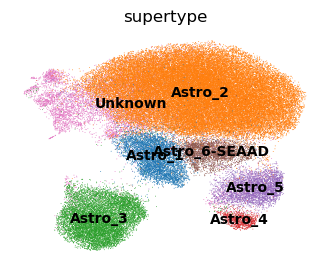

In [19]:
sc.pl.umap(adata, color='supertype', legend_loc='on data', frameon=False, sort_order=False, na_in_legend=False)

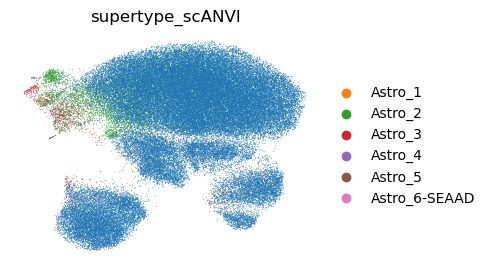

In [20]:
sc.pl.umap(adata, color='supertype_scANVI', frameon=False, sort_order=False, na_in_legend=False)

/var/folders/fh/8r6dn5450_n5z_dymgpzs_j80000gn/T/ipykernel_36535/3678267807.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = adata.obs.loc[:, ["leiden", k]].groupby("leiden").mean().loc[:, k].to_dict()


['58', '67', '90']


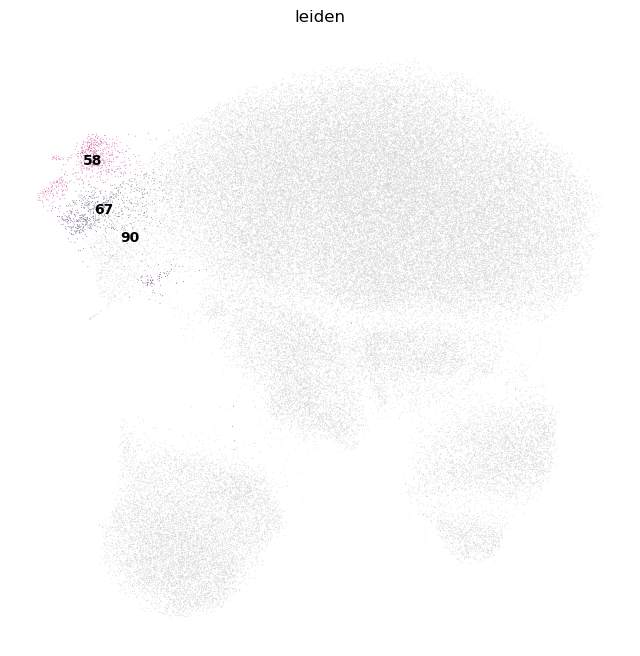

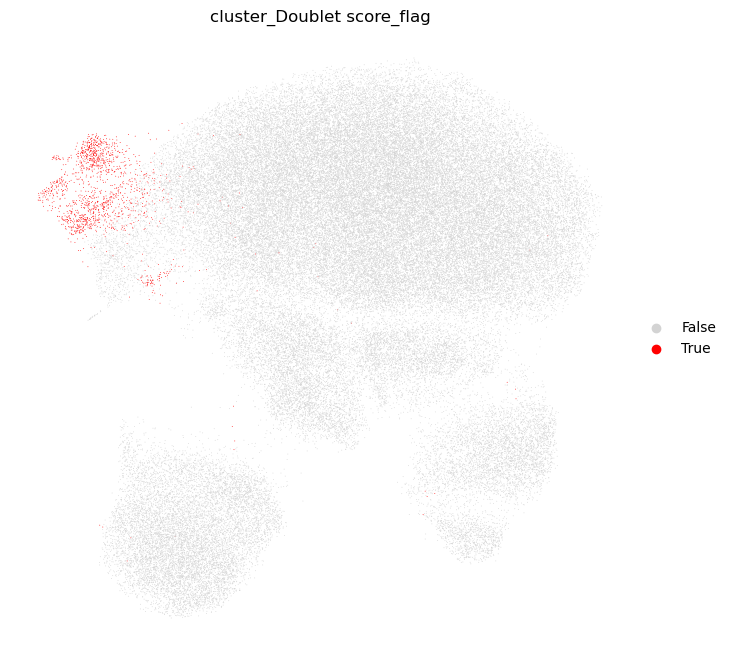

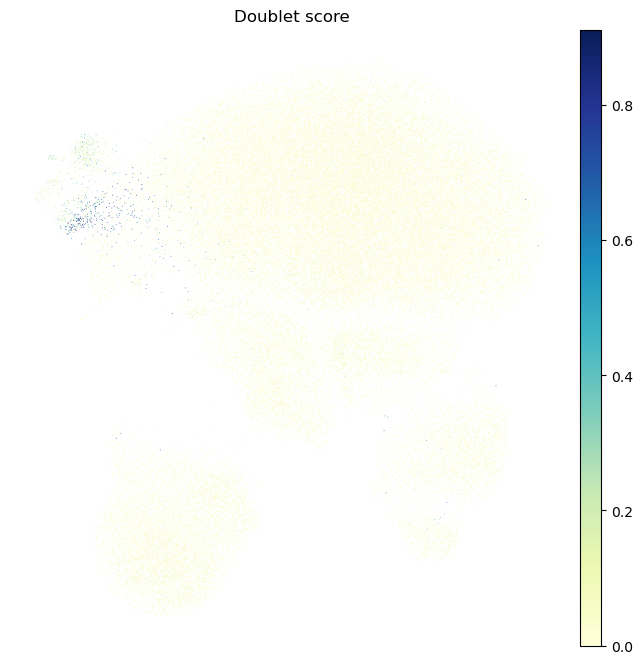

/var/folders/fh/8r6dn5450_n5z_dymgpzs_j80000gn/T/ipykernel_36535/3678267807.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = adata.obs.loc[:, ["leiden", k]].groupby("leiden").mean().loc[:, k].to_dict()


['23']


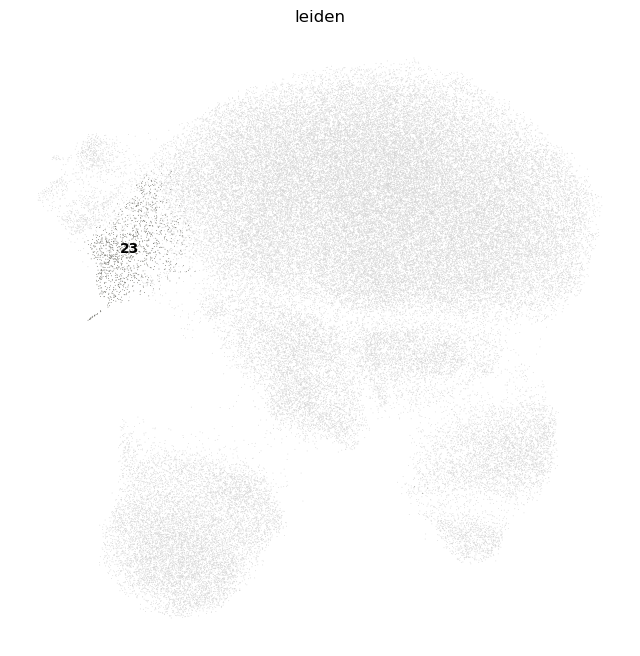

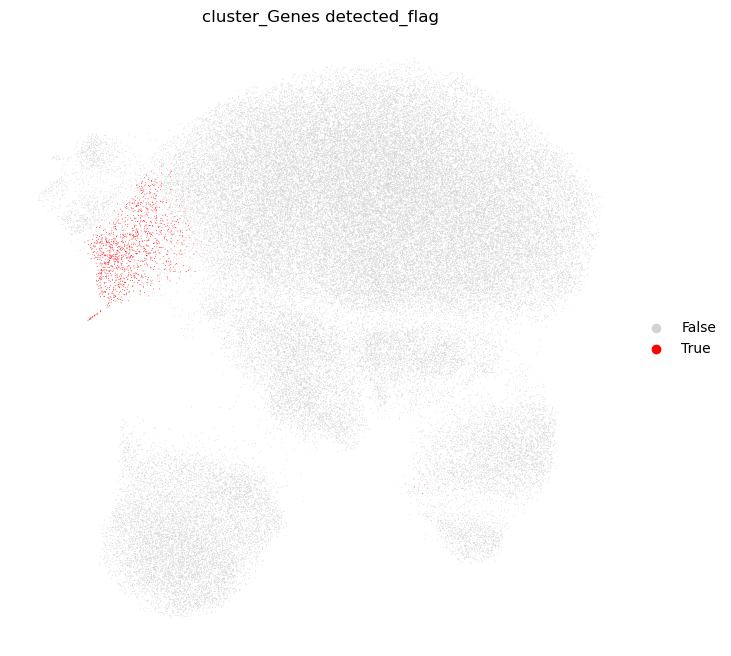

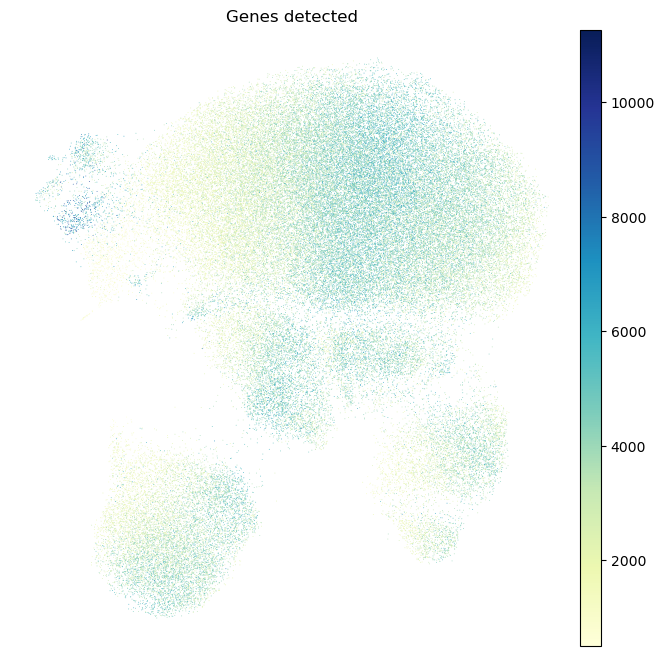

/var/folders/fh/8r6dn5450_n5z_dymgpzs_j80000gn/T/ipykernel_36535/3678267807.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = adata.obs.loc[:, ["leiden", k]].groupby("leiden").mean().loc[:, k].to_dict()


['19', '23', '31', '34']


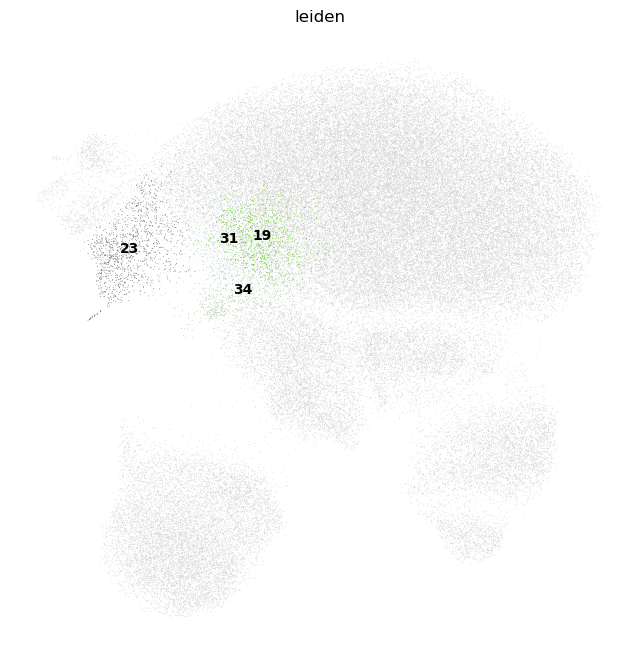

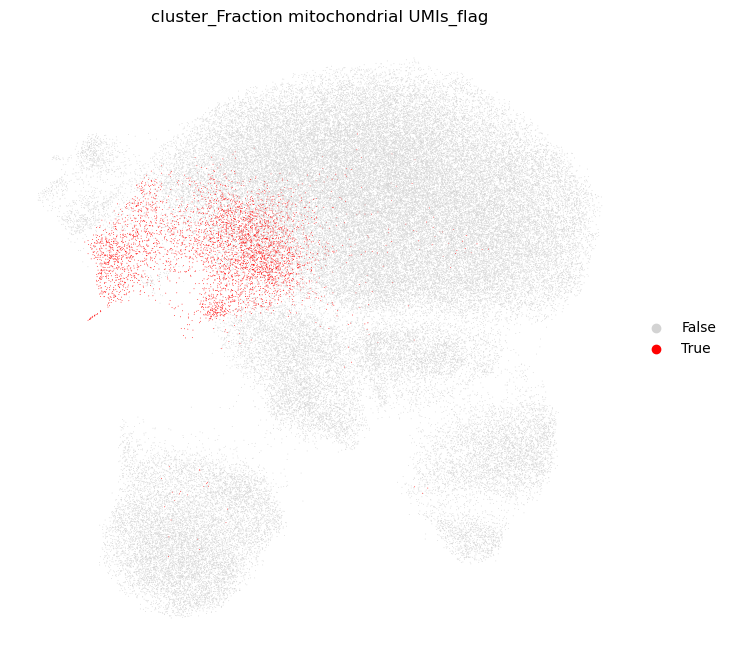

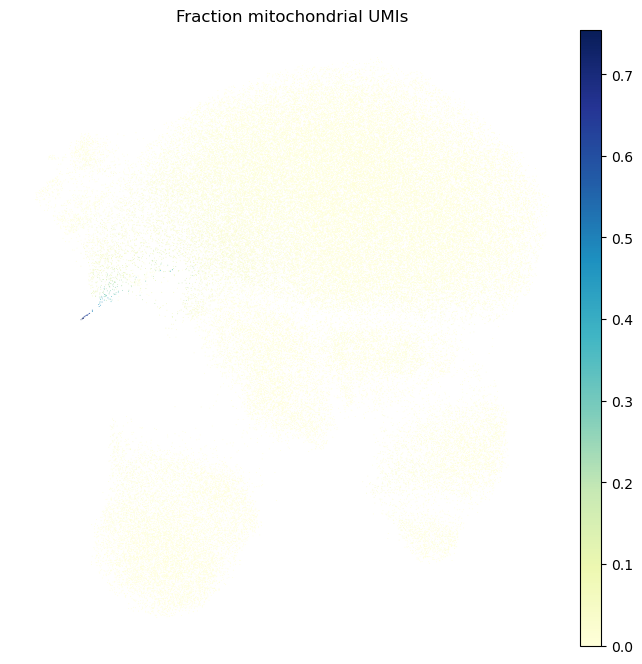

In [21]:
qc_thresh = [0.08, 1500, 0.020]
qc_dir = ["gt", "lt", "gt"]
adata = flag_and_plot_QC(adata, qc_thresh, qc_vars, qc_dir)

/var/folders/fh/8r6dn5450_n5z_dymgpzs_j80000gn/T/ipykernel_36535/3678267807.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = adata.obs.loc[:, ["leiden", k]].groupby("leiden").mean().loc[:, k].to_dict()


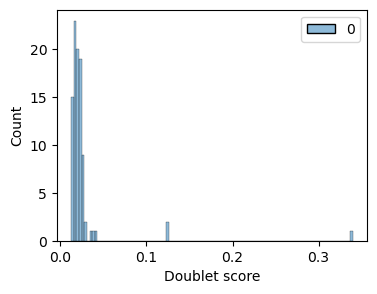

/var/folders/fh/8r6dn5450_n5z_dymgpzs_j80000gn/T/ipykernel_36535/3678267807.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = adata.obs.loc[:, ["leiden", k]].groupby("leiden").mean().loc[:, k].to_dict()


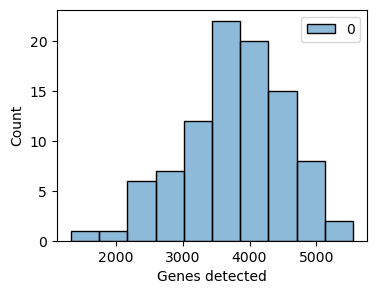

/var/folders/fh/8r6dn5450_n5z_dymgpzs_j80000gn/T/ipykernel_36535/3678267807.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = adata.obs.loc[:, ["leiden", k]].groupby("leiden").mean().loc[:, k].to_dict()


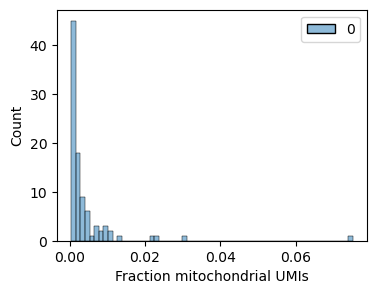

In [22]:
plot_QC_metrics_dist(adata, qc_vars)